In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transduction.lazy import Lazy, LazyDeterminize
from transduction.fsa import FSA, EPSILON
from transduction import (
    FST, EPSILON, PrecoverDecomp, examples, Precover,
    LazyRecursive, BuggyLazyRecursive, EagerNonrecursive, LazyPrecoverNFA, LazyNonrecursive,    
)
from transduction.util import display_table

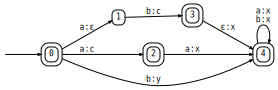

In [3]:
#fst = examples.replace([('1', 'a'), ('2', 'b'), ('3', 'c'), ('4', 'd'), ('5', 'e')])
fst = examples.samuel_example()
target = 'c'
fst.graphviz(fmt_node=lambda x: x)

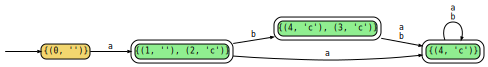

In [4]:
precover = Precover(fst, target)
precover

Target-side buffering pushes the target string into the state of the (infinite-state) machine.

In [5]:
class TargetSideBuffer(Lazy):

    def __init__(self, f):
        self.f = f

    def arcs(self, state):
        (i, ys) = state
        for x,y,j in self.f.arcs(i):
            yield x, (j, ys + y)

    def start(self):
        for i in self.f.I:
            yield (i, '')

    def is_final(self, state):
        return True

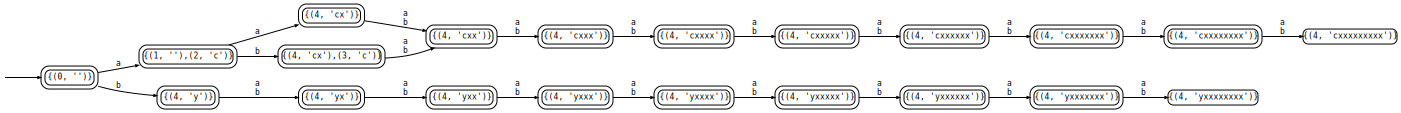

In [6]:
TargetSideBuffer(fst).det().materialize(20)   # truncated because it is infinite state

This machine has a lot of irrelevant states for our specific target string, so we can prune its arcs.

In [7]:
class Relevance(Lazy):

    def __init__(self, base, target):
        self.base = base
        self.target = target

    def arcs(self, state):
        N = len(self.target)
        for x, (i, ys) in self.base.arcs(state):
            if self.target.startswith(ys) or ys.startswith(self.target):
                yield x, (i, ys)

    def start(self):
        yield from self.base.start()

    def is_final(self, state):
        (i, ys) = state
        return self.base.is_final(state) and ys.startswith(self.target)

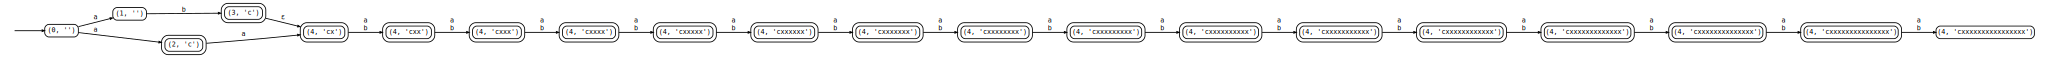

In [8]:
Relevance(TargetSideBuffer(fst), target).materialize(20)

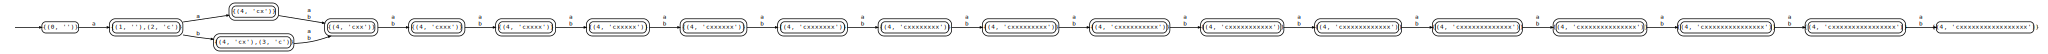

In [9]:
LazyDeterminize(Relevance(TargetSideBuffer(fst), target)).materialize(20)

The state machine above is infinite, but if we stare at its states, we realize that there is no need to keep tracking the target-side string after we have emitted the target string.  And, that is sufficient for us to tie the knot.  **Unfortunately, we lose the state information needed for tracking extensions of the target string.**

In [10]:
class Truncate(Lazy):

    def __init__(self, base, target):
        self.base = base
        self.target = target

    def arcs(self, state):
        N = len(self.target)
        for x, (i, ys) in self.base.arcs(state):
            yield x, (i, ys[:N])

    def start(self):
        yield from self.base.start()

    def is_final(self, state):
        (i, ys) = state
        return self.base.is_final(state) and ys.startswith(self.target)

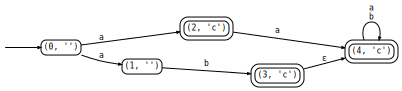

In [11]:
Truncate(Relevance(TargetSideBuffer(fst), target), target).materialize(20)

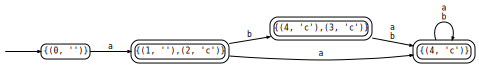

In [12]:
LazyDeterminize(Truncate(Relevance(TargetSideBuffer(fst), target), target)).materialize(20)

Determinization still works

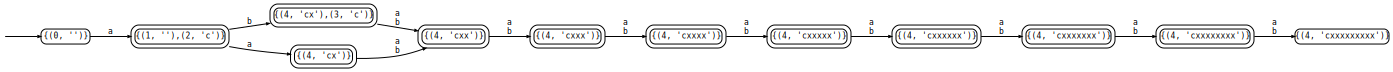

In [13]:
#D = materialize(LazyDeterminize(Truncate(Relevance(TargetSideBuffer(fst), target), target)), 20)
DD = LazyDeterminize(Relevance(TargetSideBuffer(fst), target))
D = DD.materialize(12)
D

In [14]:
def continuity(self, frontier, target, alphabet):

    def refine(frontier):
        # Clip the target string state variable to `target`, as this mimics the states of 
        # the composition machine for the complete string `target`, we haven't limited it 
        # to this point, which means that we have an infinite-state machine.
        N = len(target)
        return frozenset({
            (i, ys[:N]) for i, ys in frontier
            if ys[:N].startswith(target)
        })

    def arcs(i):
        for x, j in self.arcs(i):
            yield x, j

    def is_final(xs):
        return any(ys.startswith(target) for i, ys in frontier if fst.is_final(i))

    worklist = []
    worklist.append(frontier)
    visited = {refine(frontier)}
    while worklist:
        i = worklist.pop()
        if not is_final(i): return False
        dest = dict(arcs(i))
        for a in alphabet:
            if a not in dest: return False
            j = dest[a]
            jj = refine(j)
            if jj not in visited:
                visited.add(jj)
                worklist.append(j)
    return True

In [15]:
for i in sorted(D.states, key=lambda i: max(ys for _, ys in i)):
    print(i)
    states = {j for j, _ in i}
    print((colors.light.green % 'UNIVERSAL') if continuity(DD, i, target, fst.A - {EPSILON}) else 'not universal')
    display_table([[fst.graphviz(sty_node=lambda x: {
        'style': 'filled,rounded',
        'fillcolor': '#F9E6E6' if x in states else '#ffffff',
    }), D.graphviz(sty_node=lambda x: {
        'style': 'filled,rounded',
        'fillcolor': '#F9E6E6' if x == i else '#ffffff',
    })]])

{(0, '')}
not universal


{(1, ''),(2, 'c')}
UNIVERSAL


{(4, 'cx'),(3, 'c')}
UNIVERSAL


{(4, 'cx')}
UNIVERSAL


{(4, 'cxx')}
UNIVERSAL


{(4, 'cxxx')}
UNIVERSAL


{(4, 'cxxxx')}
UNIVERSAL


{(4, 'cxxxxx')}
UNIVERSAL


{(4, 'cxxxxxx')}
UNIVERSAL


{(4, 'cxxxxxxx')}
UNIVERSAL


{(4, 'cxxxxxxxx')}
UNIVERSAL


{(4, 'cxxxxxxxxx')}
UNIVERSAL


In [64]:
from transduction import peekaboo_nonrecursive
from transduction import peekaboo_recursive
from transduction import LazyPrecoverNFA
from transduction.eager_nonrecursive import LazyPrecoverNFAWithTruncationMarker

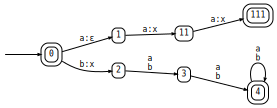

In [88]:
#fst = examples.triplets_of_doom()
fst = examples.lookahead()
target = 'x'
fst

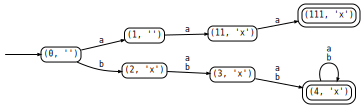

In [89]:
LazyPrecoverNFA(fst, target).materialize()

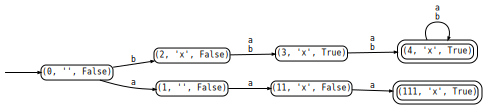

In [90]:
LazyPrecoverNFAWithTruncationMarker(fst, target).materialize()

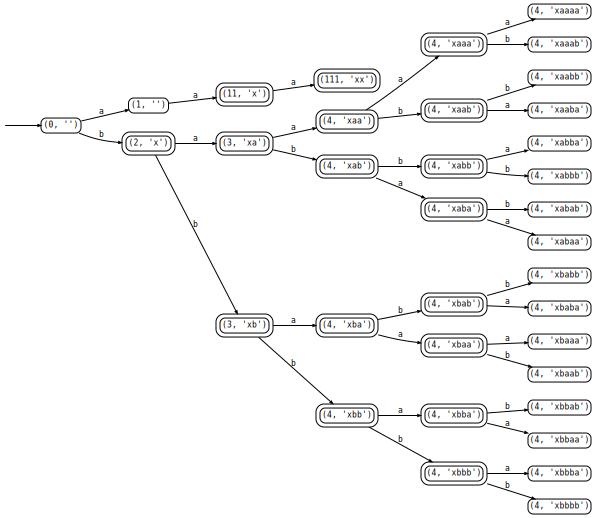

In [91]:
Relevance(TargetSideBuffer(fst), target).materialize(20)

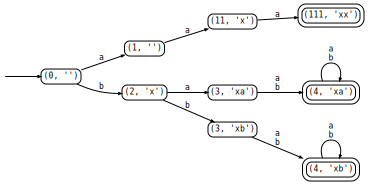

In [92]:
peekaboo_nonrecursive.PeekabooPrecover(fst, target).materialize(100)

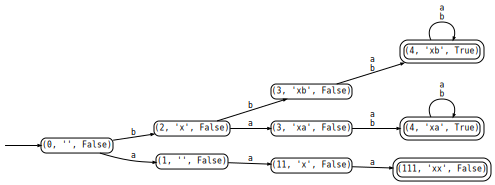

In [93]:
peekaboo_recursive.PeekabooPrecover(fst, target).materialize()

In [96]:
want = peekaboo_recursive.PeekabooPrecover(fst, target, K=1).materialize()
for K in range(1, 14):
    print(f'{K=}')
    have = peekaboo_recursive.PeekabooPrecover(fst, target, K=K).materialize()
    assert have.equal(want)

K=1
K=2
K=3
K=4
K=5
K=6
K=7
K=8
K=9
K=10
K=11
K=12
K=13
